In [1]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings("ignore")

In [2]:
%%time
trans = pd.read_parquet('./hack_data/transactions.parquet', engine='pyarrow', use_threads=True)

CPU times: user 23.9 s, sys: 34.7 s, total: 58.6 s
Wall time: 1min 8s


In [3]:
rows_number =  10 ** 7
trans_short = trans.iloc[:rows_number]
# trans_short = trans.iloc[-rows_number:]

trans_short = trans_short[['plant', 'client_id', 'chq_date', 'sales_count', 'sales_sum', 'material']]

le = preprocessing.LabelEncoder()
trans_short['client_id'] = le.fit_transform(trans_short['client_id'])
trans_short['product_id'] = le.fit_transform(trans_short['material'])
trans_short['shop_id'] = le.fit_transform(trans_short['plant'])
trans_short = trans_short.drop(columns=['material', 'plant'])

In [4]:
del trans

In [10]:
trans_short[trans_short['shop_id'] == 211]['product_id'].value_counts().index[:30].values

array([63730,  6914, 34178, 78523, 74705, 37420, 59421, 37616,  5149,
       77897, 41056, 32683, 81783, 25340, 59000, 31216, 83335,  2074,
       41103, 28623, 17641, 63645, 12038, 38424, 67002, 70441, 70978,
        4791,  9284, 42492])

In [11]:
trans_short['shop_id'].value_counts().index[:30].values

array([211,  55,  88, 142, 139, 247, 146, 213, 184,  68, 248, 284,  80,
        54, 238,  18,   2, 320, 109, 175,  14,  64, 290, 192, 219, 231,
       105, 300,  96, 352])

## Example data

In [12]:
example_product_id = 63730

product_df = trans_short[trans_short['product_id'] == example_product_id][['chq_date', 'sales_count']]
product_df = product_df.sort_values(by=['chq_date'])
product_df = product_df.groupby(['chq_date'], as_index=False).sum()
product_df['day_number'] = le.fit_transform(product_df['chq_date'])

In [13]:
product_df

,chq_date,sales_count,day_number
0,2016-10-26,2202.0,0
1,2016-10-28,2705.0,1
2,2016-10-30,3038.0,2
3,2016-11-01,2360.0,3
4,2016-11-02,2303.0,4
...,...,...,...
133,2017-07-25,392.0,133
134,2017-07-26,409.0,134
135,2017-07-27,471.0,135
136,2017-08-24,448.0,136


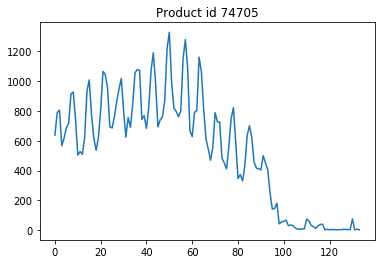

In [53]:
plt.plot(product_df.day_number, product_df.sales_count)
plt.title('Product id {}'.format(example_product_id))
plt.show()

In [54]:
start_prediction_day = 70

train_dates = product_df[product_df['day_number'] <= start_prediction_day]['chq_date']
train_dates = [str(el)[:10] for el in train_dates.values]
train_demand = product_df[product_df['day_number'] <= start_prediction_day]['sales_count'].values

test_days_num = 14
test_dates = product_df[product_df['day_number'] > start_prediction_day]['chq_date'][:test_days_num]
test_dates = [str(el)[:10] for el in test_dates.values]
test_demand = product_df[product_df['day_number'] > start_prediction_day]['sales_count'].values[:test_days_num]

# Holt’s Damped Trend

In [55]:
model = ExponentialSmoothing(train_demand, trend='mul', seasonal='add', seasonal_periods=7)
fit = model.fit()
predictions = fit.forecast(test_days_num)

### Predictions visualization

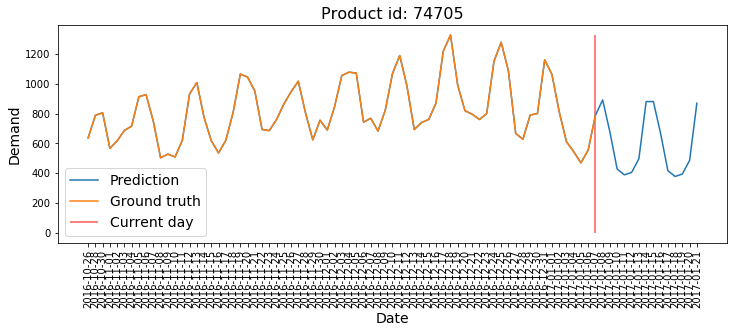

In [56]:
plt.figure(figsize=(12,4))
plt.plot(np.arange(start_prediction_day + test_days_num + 1),
         np.concatenate([train_demand, predictions]), label='Prediction')

plt.plot(np.arange(start_prediction_day+1),
         train_demand, label='Ground truth')

plt.vlines(x=start_prediction_day, ymin=0, ymax=np.max(train_demand), color='red', alpha=0.65, label='Current day')

plt.title('Product id: {}'.format(example_product_id), fontsize=16)
plt.legend(fontsize=14, loc='lower left')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Demand', fontsize=14)
plt.xticks(np.arange(start_prediction_day + test_days_num + 1),
           np.concatenate([train_dates, test_dates]),
           rotation=90)
# plt.grid()
plt.savefig('./pics/demand_product_id_{}.pdf'.format(example_product_id))
plt.show()

### to csv

In [57]:
train_df = pd.DataFrame(data=np.array([train_dates, train_demand]).T, columns=['train_date', 'demand'])
predictions_df = pd.DataFrame(data=np.array([test_dates, predictions]).T, columns=['test_date', 'predictions'])

In [58]:
curr_day = str(product_df['chq_date'].values[start_prediction_day])[:10]


train_df.to_csv('./for_excel/demand_train_product_id_{}_current_day_{}.csv'.format(example_product_id,
                                                                                   curr_day),
                index=False)



In [59]:
predictions_df.to_csv('./for_excel/demand_prediction_product_id_{}_current_day_{}.csv'.format(example_product_id,
                                                                                              curr_day),
                index=False)



### RMSE calculation

In [40]:
test_days_num = 14
rmse_lst = []



for start_prediction_day in range(2 * test_days_num, product_df.shape[0] - 2 * test_days_num):
    train_dates = product_df[product_df['day_number'] <= start_prediction_day]['chq_date']
    train_dates = [str(el)[:10] for el in train_dates.values]
    train_demand = product_df[product_df['day_number'] <= start_prediction_day]['sales_count'].values

    test_days_num = 14
    test_dates = product_df[product_df['day_number'] > start_prediction_day]['chq_date'][:test_days_num]
    test_dates = [str(el)[:10] for el in test_dates.values]
    test_demand = product_df[product_df['day_number'] > start_prediction_day]['sales_count'].values[:test_days_num]
    
    model = ExponentialSmoothing(train_demand, trend='mul', seasonal='add', seasonal_periods=7)
    fit = model.fit()
    predictions = fit.forecast(test_days_num)
    
    if not np.isnan(predictions).any():
        rmse_lst.append(np.sqrt(mean_squared_error(predictions, test_demand)))
        
        
print('RMSE value: ', np.mean(rmse_lst))

KeyboardInterrupt: 

# Widget function

In [5]:
def predict_demand(data, product_id, shop_id, current_date, prediction_length=14):
    try:
        product_df = data[(data['product_id'] == product_id) & (data['shop_id'] == shop_id)]
        product_df = product_df[['chq_date', 'sales_count']]
        product_df['chq_date'] = pd.to_datetime(trans_short['chq_date'])
        product_df = product_df.sort_values(by=['chq_date'])
        product_df = product_df.groupby(['chq_date'], as_index=False).sum()
        le = preprocessing.LabelEncoder()
        product_df['day_number'] = le.fit_transform(product_df['chq_date'])

        train_demand = product_df[product_df['chq_date'] <= current_date]['sales_count'].values

        model = ExponentialSmoothing(train_demand, trend='mul', seasonal='add', seasonal_periods=7)
        fit = model.fit()
        predictions = fit.forecast(prediction_length)
    except:
        predictions = []
    return predictions

In [11]:
pd.to_datetime(trans_short['chq_date']).values

array(['2016-11-01T00:00:00.000000000', '2016-11-01T00:00:00.000000000',
       '2016-11-01T00:00:00.000000000', ...,
       '2017-02-03T00:00:00.000000000', '2017-02-03T00:00:00.000000000',
       '2017-02-03T00:00:00.000000000'], dtype='datetime64[ns]')

In [7]:
predict_demand(data=trans_short, shop_id=211, product_id=63730,
               current_date=np.datetime64('2016-12-30'))

array([24.47805408, 26.49977266, 27.25480534, 20.64347271, 23.74478716,
       20.2594836 , 23.19827384, 24.13498734, 26.15726274, 26.91285134,
       20.30207373, 23.40394229, 19.91919196, 22.85853451])

In [13]:
predict_demand(data=trans_short, shop_id=55, product_id=6914,
               current_date=np.datetime64('2016-12-30'))

array([ 0.22398546, -6.18742572,  3.5166605 ,  2.03668438, 15.91127207,
       13.64706176,  3.10136989,  0.84285788, -5.64275209,  3.9960313 ,
        2.45858173, 16.28258667, 13.97385815,  3.38898552])

# Baseline: simple exp smoothing

In [249]:
def get_coeffs(N=10, q=0.8):
    start = [q]
    for i in range(N - 1):
        start.append(start[-1]*q)
    summ = sum(start)
    return [i/summ for i in start][::-1]

In [250]:
N_prev_to_predict = 20
coeffs = get_coeffs(N=N_prev_to_predict, q=0.9)

predictions = []
for day in range(test_days_num):
    prev_N_days = np.concatenate([train_demand, predictions])[-N_prev_to_predict:]
    predictions.append(np.sum(prev_N_days * coeffs))

### Predictions visualization

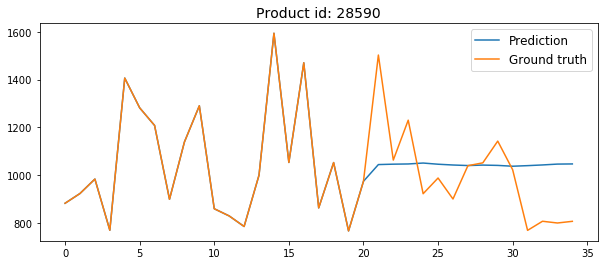

In [251]:
plt.figure(figsize=(10,4))
plt.plot(np.arange(start_prediction_day + test_days_num + 1),
         np.concatenate([train_demand, predictions]), label='Prediction')

plt.plot(np.arange(start_prediction_day + test_days_num + 1),
         np.concatenate([train_demand, test_demand]), label='Ground truth')

plt.title('Product id: {}'.format(example_product_id), fontsize=14)
plt.legend(fontsize=12)
plt.show()